#### This notebook is a demonstration of the pixel classification logic using a facsimile of a panel from an x-ray detector 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import scipy.ndimage 
import scipy.misc
from scipy.stats import multivariate_normal as mvn
from scipy.sparse import triu
from sklearn.mixture import GaussianMixture
import sys
np.seterr(invalid='ignore')

sys.path.insert(0, '/Users/vanessa/work/repos/pixel_masking/src')

import pixel_classification as pc

#### Create a fake image 

In [40]:
# Create image with intensities randomly sampled from 2 Gaussian distributions
import random

# instantiate a matrix with values sampled from a Gaussian distribution centered on 0 with a variance of 1
center = scipy.stats.norm(0,0.2)
c = center.rvs(size=10000) 
c = c.reshape(100,100)

# add a gradient (to simulate water x-ray scattering)
grad = np.linspace(0,2,100)
for col in range(c.shape[1]):
    c[:,col] = c[:,col] + grad[col]

rv = scipy.stats.norm(50,1) # Instantiate a second distribution of "bad pixels" 
coords = []
# insert bad pixels at random locations 
for i in range(200):
    x = random.randint(0, 99)
    y = random.randint(0, 99)
    c[x,y] = rv.rvs(size=1)
    coords.append((x,y))
    
# insert bad border pixels to mimic common detector pathologies   
for i in range(100):
    val = rv.rvs(size=1)
    c[i,99] = val
    coords.append((i,99))

# Insert a uniformly hot section in a panel to mimic a different detector pathology    
for i in range(20):
    for j in range(20):
        c[x+i,y+j] = 10
        c[x+j,y+i] = 10
        coords.append((x+i,y+j))
        coords.append((x+j,y+i))
        
        

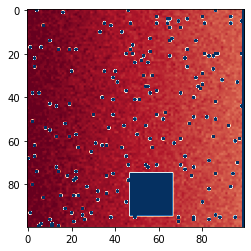

In [41]:
plt.imshow(c,vmin=0.0, vmax=10,cmap='RdBu');

##### Instantiate a class of the pixel classifier

In [42]:
pix_classes = pc.pixel_classifier(c,IC_threshold=200, rescale_data=False,image_shape=[100,100])

model len 10
EM algorithm converged?: True
Found 4 different distributions in best Gaussian mixture model
means: [0.056545412960714914, 48.621663171722176, -48.970917685205, -8.74474073868117]
variances: [0.3986046072454862, 1.829391186166248, 1.9860331922419538, 0.06190189931960442]


Compare mean and variances with that of the distribution used to create this data

In [37]:
print(f'mean: {rv.mean()} variance: {rv.var()}')

mean: 50.0 variance: 1.0


In [29]:
classed_image = pix_classes.label_bad_pixels()

855 out of 1100 pre-assigned bad pixels were classified bad
1017 of pixels classified as bad were in the location they were expected to be found
9145 pixels were classified as good


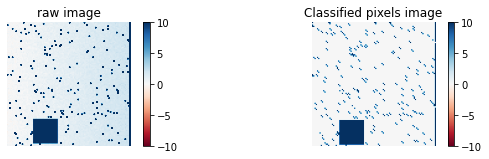

In [30]:
missed_pix = []
found_pix = []
for pix in coords:
    x = pix[0]
    y = pix[1]
    if classed_image[x,y] == 10:
        found_pix.append(c[x,y])
    elif classed_image[x,y] != 10:
        missed_pix.append(c[x,y])
bad = np.where(classed_image==10)
good = np.where(classed_image==0)
print(f'{len(bad[0])} out of {len(coords)} pre-assigned bad pixels were classified bad')
print(f'{len(found_pix)} of pixels classified as bad were in the location they were expected to be found')
print(f'{len(good[0])} pixels were classified as good')
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(221)
ax.set_title("raw image")
p1 = ax.imshow(c,vmin=-10, vmax=10,cmap='RdBu');
f.colorbar(p1,ax=ax);
ax.axis('off');
ax2 = f.add_subplot(222)
ax2.set_title("Classified pixels image")
p2 = ax2.imshow(classed_image,vmin=-10, vmax=10,cmap='RdBu');
f.colorbar(p1,ax=ax2);
ax2.axis('off');